In [1]:
import os
import sys
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

import matplotlib.pyplot as plt
from tqdm import tqdm

root_dir = os.getcwd().split("AdversarialNIDS")[0] + "AdversarialNIDS"
sys.path.append(root_dir)

from scripts.logger import LoggerManager
from scripts.analysis.model_analysis import perform_model_analysis

from CICIDS2017.preprocessing.dataset import CICIDS2017
from UNSWNB15.preprocessing.dataset import UNSWNB15

from scripts.models.pytorch.MLP import NetworkIntrusionMLP
from scripts.models.pytorch.CNN import NetworkIntrustionCNN
from scripts.models.pytorch.LSTM import NetworkIntrusionLSTM

from scripts.models.pytorch.train import train
from scripts.models.pytorch.visualization import display_loss

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

lm = LoggerManager(log_dir=f"{root_dir}/logs", log_name="TDM")
logger = lm.get_logger()
title = lm.get_title()
logger.info(f"Logger initialized for '{title}'")

c:\Users\valen\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-21 15:58:51,015 - INFO - Logger initialized for 'TDM_20251121_155851'


In [2]:
logger = LoggerManager(log_name="rf_notebook").get_logger()
logger.info("Starting Random Forest training notebook")

dataset = UNSWNB15(dataset_size="small",logger=logger).optimize_memory().encode().scale().subset(size=100000, multi_class=True)

2025-11-21 15:58:54,153 - INFO - Starting Random Forest training notebook
2025-11-21 15:58:54,156 - INFO - Downloading dataset: mrwellsdavid/unsw-nb15
2025-11-21 15:59:02,887 - INFO - Loaded UNSW-NB15_1.csv with shape: (700000, 46)
2025-11-21 15:59:02,905 - INFO - DataFrame shape: (700000, 46)
2025-11-21 15:59:02,907 - INFO - Initial dimensions: 700,000 rows x 46 columns = 32,200,000 cells
2025-11-21 15:59:07,327 - INFO - ============================================================
2025-11-21 15:59:07,329 - INFO - Preprocessing completed successfully
2025-11-21 15:59:07,329 - INFO - Final dimensions: 640,658 rows x 46 columns
2025-11-21 15:59:07,330 - INFO - Total rows removed: 59,342 (8.48%)
2025-11-21 15:59:07,332 - INFO - data retention rate: 91.52%
2025-11-21 15:59:07,332 - INFO - ============================================================
2025-11-21 15:59:07,454 - INFO - Optimizing memory usage of the dataset...
2025-11-21 15:59:07,486 - INFO - Initial memory usage: 229.73 MB
202

In [5]:
X_train, X_test, y_train, y_test = dataset.split(test_size=0.2, apply_smote=True)
print(f"Train set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

2025-11-21 15:59:53,586 - INFO - Splitting dataset into training and testing sets...
2025-11-21 15:59:53,598 - INFO - Class distribution before SMOTE:
2025-11-21 15:59:56,827 - INFO - Applied SMOTE to balance the training set.
2025-11-21 15:59:56,829 - INFO - Class distribution after SMOTE:
2025-11-21 15:59:56,830 - INFO -   Class 0: 7980 samples
2025-11-21 15:59:56,831 - INFO -   Class 1: 7980 samples
2025-11-21 15:59:56,833 - INFO -   Class 2: 7980 samples
2025-11-21 15:59:56,835 - INFO -   Class 3: 7980 samples
2025-11-21 15:59:56,836 - INFO -   Class 4: 7980 samples
2025-11-21 15:59:56,839 - INFO -   Class 5: 7980 samples
2025-11-21 15:59:56,841 - INFO -   Class 6: 7980 samples
2025-11-21 15:59:56,842 - INFO -   Class 7: 7980 samples
2025-11-21 15:59:56,843 - INFO -   Class 8: 7980 samples
2025-11-21 15:59:56,845 - INFO -   Class 9: 7980 samples


Train set shape: (79800, 45)
Test set shape: (4856, 45)


In [6]:
from scripts.models.random_forest.random_forest import train_random_forest
# Train Random Forest using standalone function and plot CV scores
logger.info("Training Random Forest with cross-validation using train_random_forest...")
rf_model, cv_scores = train_random_forest(
    X_train,
    y_train,
    n_estimators=10,
    max_depth=3,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=0,
    cv=5,
    class_weight='balanced',
    logger=None
)
if cv_scores!= None:
    print("\n" + "="*50)
    print("CROSS-VALIDATION RESULTS")
    print("="*50)
    print(f"CV Scores: {cv_scores}")
    print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    # Plot CV scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cv_scores)+1), cv_scores, marker='o', markersize=10, linewidth=2, color='green')
    plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', 
                label=f'Mean: {cv_scores.mean():.4f}')
    plt.xlabel('Fold', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Decision Tree Cross-Validation Scores', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

2025-11-21 15:59:59,585 - INFO - Training Random Forest with cross-validation using train_random_forest...


2025-11-21 16:00:01,900 - INFO - Running analysis for scikit-learn model: RandomForest


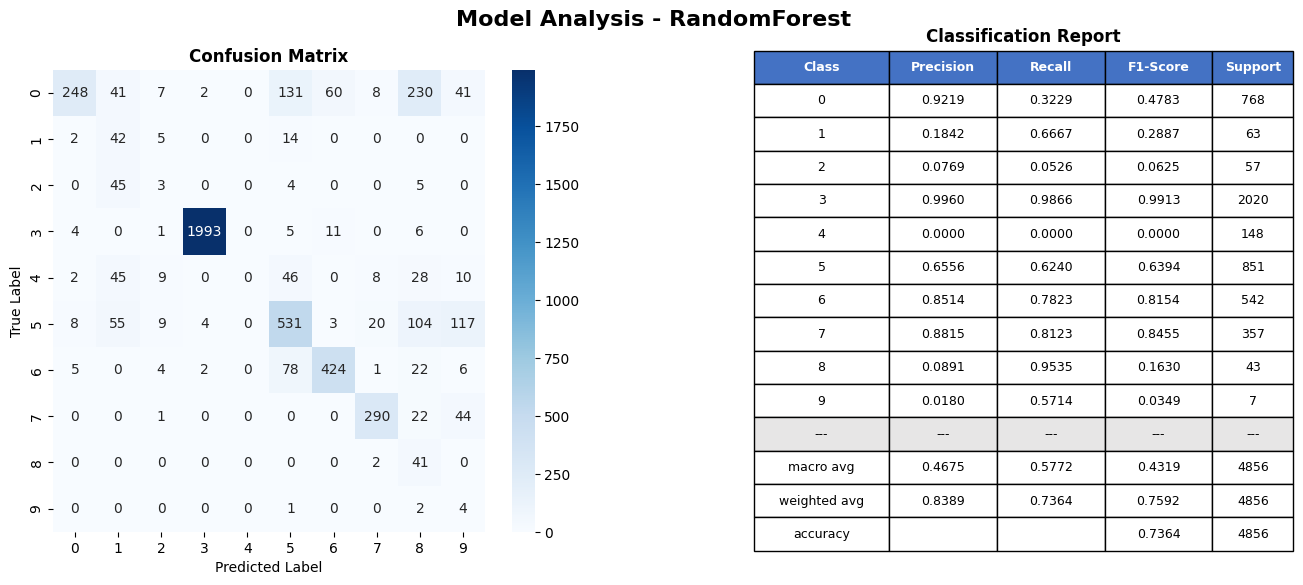

In [7]:
# Evaluate model
cm_rf, cr = perform_model_analysis(
    model=rf_model,
    X_test=X_test,
    y_test=y_test,
    logger=logger,
    model_name="RandomForest",
    dir=os.getcwd(),
    plot=True
)

In [8]:
from scripts.models.model_utils import (
    check_data_leakage,
    get_tree_feature_importance    
)

# Get feature importance
top_features = get_tree_feature_importance(
    rf_model,
    feature_names=list(dataset.data.columns),
    top_n=15,
    logger=logger
)

# Plot feature importance
features, importances = zip(*top_features)

plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(features)))
plt.barh(range(len(features)), importances, color=colors)
plt.yticks(range(len(features)), features)
plt.xlabel('Importance', fontsize=12)
plt.title('Top 15 Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

2025-11-21 16:00:42,664 - INFO - Top 15 most important features:
2025-11-21 16:00:42,665 - INFO - 1. Destination Port: 0.0962
2025-11-21 16:00:42,665 - INFO - 2. ct_state_ttl: 0.0869
2025-11-21 16:00:42,666 - INFO - 3. Ltime: 0.0819
2025-11-21 16:00:42,666 - INFO - 4. service: 0.0811
2025-11-21 16:00:42,667 - INFO - 5. sttl: 0.0762
2025-11-21 16:00:42,667 - INFO - 6. Stime: 0.0746
2025-11-21 16:00:42,668 - INFO - 7. ct_dst_sport_ltm: 0.0736
2025-11-21 16:00:42,668 - INFO - 8. state: 0.0723
2025-11-21 16:00:42,669 - INFO - 9. sport: 0.0667
2025-11-21 16:00:42,669 - INFO - 10. Total Length of Fwd Packets: 0.0451
2025-11-21 16:00:42,669 - INFO - 11. ct_srv_dst: 0.0362
2025-11-21 16:00:42,670 - INFO - 12. tcprtt: 0.0273
2025-11-21 16:00:42,670 - INFO - 13. ct_src_dport_ltm: 0.0254
2025-11-21 16:00:42,671 - INFO - 14. Avg Fwd Segment Size: 0.0241
2025-11-21 16:00:42,671 - INFO - 15. Fwd Packets/s: 0.0220


NameError: name 'np' is not defined

<Figure size 1200x800 with 0 Axes>

Part 2: Training of the surrogate

In [9]:
import numpy as np
input_size = dataset.scaled_features.shape[1]
num_classes = np.size(dataset.attack_classes[0])

In [10]:
class NetworkIntrusionMLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NetworkIntrusionMLP, self).__init__()

        self.features = nn.Sequential(
            nn.Linear(input_size, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
        )

        self.classifier1 = nn.Sequential(
            nn.Linear(100, num_classes[0]),
        )

        self.classifier2 = nn.Sequential(
            nn.Linear(100 + num_classes[0], 64),
            nn.ReLU(),
            nn.Linear(64, num_classes[1]),
        )

    def forward(self, x):
        features = self.features(x)
        out1 = self.classifier1(features)
        x2 = torch.cat((features, out1), dim=1)
        out2 = self.classifier2(x2)
        return torch.softmax(out2, dim=1)

In [11]:
X_train = torch.tensor(X_train,dtype=torch.float32).to(device)
y_train = torch.tensor(y_train,dtype=torch.long).to(device)
X_test = torch.tensor(X_test,dtype=torch.float32).to(device)
y_test = torch.tensor(y_test,dtype=torch.long).to(device)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_test,y_test)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [12]:
model_mlp = NetworkIntrusionMLP(input_size=input_size, num_classes=[2, 10]).to(device)
num_parameters = sum(p.numel() for p in model_mlp.parameters() if p.requires_grad)
print(f"Number of trainable parameters in MLP model: {num_parameters}")
criterion = nn.CrossEntropyLoss()

learning_rate_mlp = 1e-2
num_epochs_mlp = 200

optimizer_mlp = optim.AdamW(model_mlp.parameters(), lr=learning_rate_mlp)
scheduler_mlp = optim.lr_scheduler.ReduceLROnPlateau(optimizer_mlp, mode='min', factor=0.8, patience=10, min_lr=1e-6)

Number of trainable parameters in MLP model: 36744


In [13]:
print(num_classes)
print(torch.unique(y_train))

1
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [14]:
model_mlp, train_losses_mlp, val_losses_mlp = train(
    model=model_mlp,
    optimizer=optimizer_mlp,
    scheduler=scheduler_mlp,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=num_epochs_mlp
)


Loss: 1.7524, Val Loss: 1.6359, LR: 0.002621: 100%|██████████| 200/200 [11:44<00:00,  3.52s/it]


2025-11-21 16:15:34,078 - INFO - Plotting loss curve...


The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


OSError: [Errno 28] No space left on device: 'c:\\msys64\\home\\valen\\TDpython\\AdversarialNIDS/loss_img/TDM_20251121_155851_MLP_loss.png'

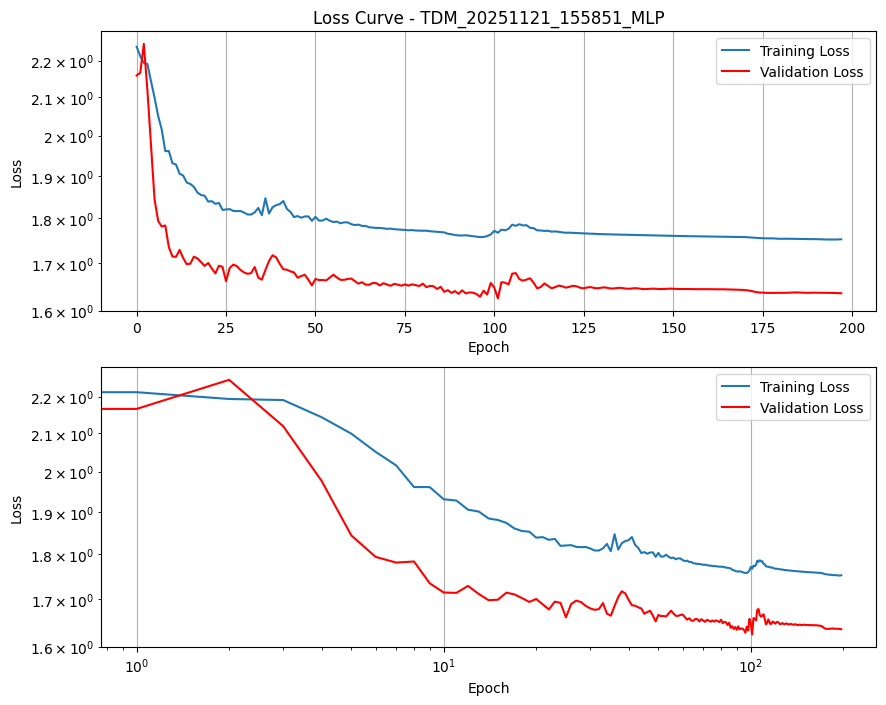

In [15]:
display_loss(
    list_epoch_loss=train_losses_mlp,
    list_val_loss=val_losses_mlp,
    title=f"{title}_MLP",
    dir=root_dir,
    logger=logger,
    epoch_min=2
)

2025-11-21 16:15:46,164 - INFO - Running analysis for PyTorch model: TDM_20251121_155851_MLP on device: cpu


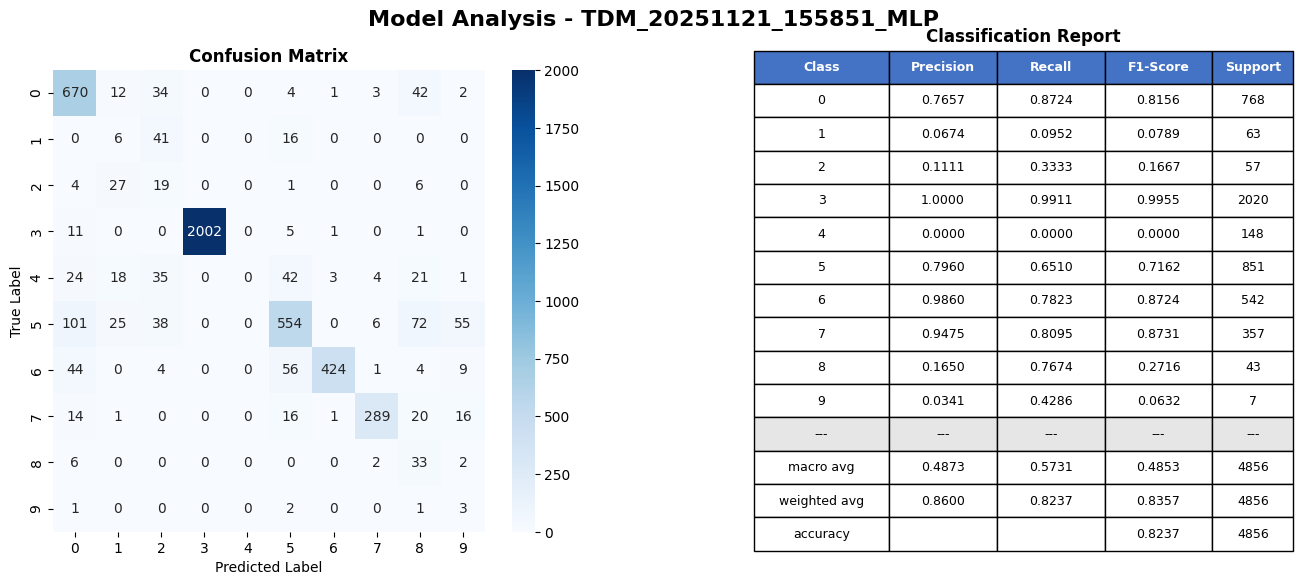

In [16]:
cm_mlp, cr = perform_model_analysis(
    model=model_mlp,
    X_test=X_test,
    y_test=y_test,
    logger=logger,
    model_name=f"{title}_MLP",
    dir=root_dir,
    plot=True,
    device=device
)

3- Attack surrogate

In [18]:
from scripts.Attack.surrogate import attack_fgsm

In [19]:
target = torch.zeros_like(y_test)
X_perturb = attack_fgsm(model_mlp,criterion,X_test,target)
for i in range(100):
    X_perturb = attack_fgsm(model_mlp,criterion,X_perturb,target)

4 - MLP Result

2025-11-21 16:16:08,191 - INFO - Running analysis for PyTorch model: TDM_20251121_155851_MLP on device: cpu


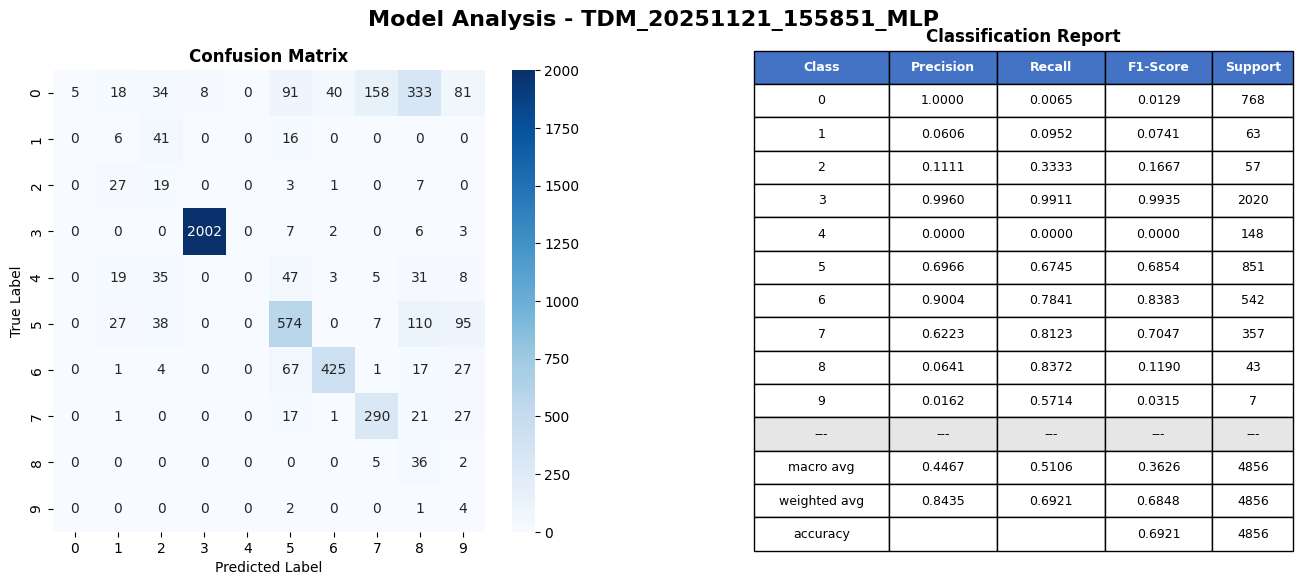

In [20]:
cm_mlp_perturb, cr = perform_model_analysis(
    model=model_mlp,
    X_test=X_perturb,
    y_test=y_test,
    logger=logger,
    model_name=f"{title}_MLP",
    dir=root_dir,
    plot=True,
    device=device
)

5- RF results

2025-11-21 16:16:28,037 - INFO - Running analysis for scikit-learn model: RandomForest


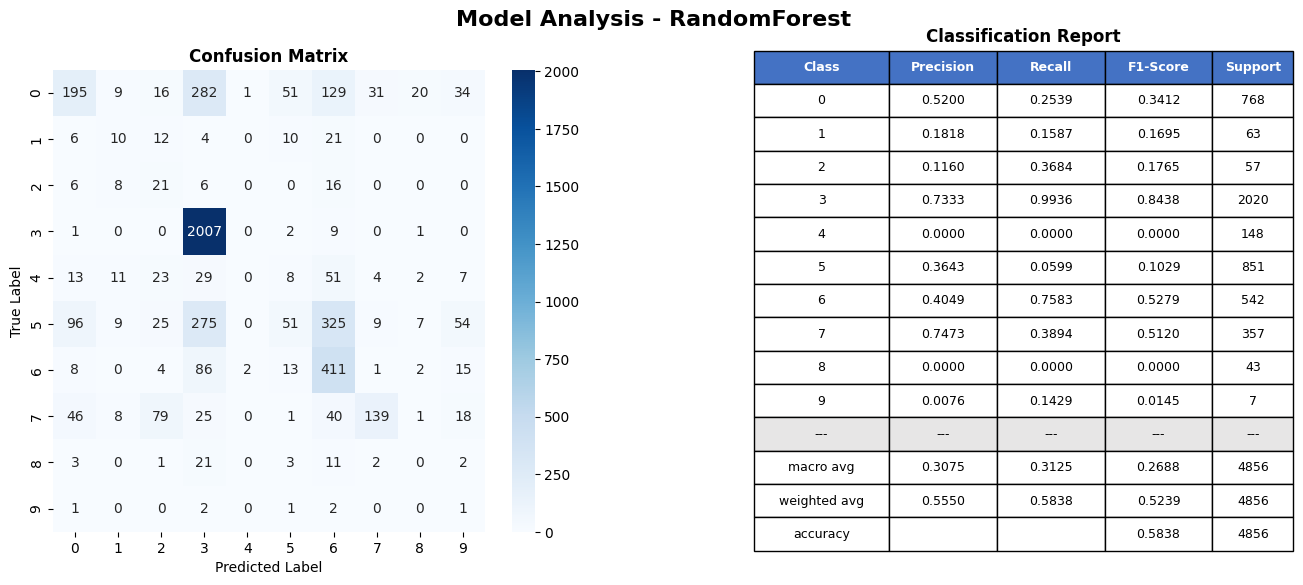

In [21]:
# Evaluate model
cm_rf_perturb, cr = perform_model_analysis(
    model=rf_model,
    X_test=X_perturb.detach().numpy(),
    y_test=y_test.detach().numpy(),
    logger=logger,
    model_name="RandomForest",
    dir=os.getcwd(),
    plot=True
)

6- Comparision

In [22]:
comp_rf = cm_rf-cm_rf_perturb
comp_mlp = cm_mlp-cm_mlp_perturb

Text(0.5, 0.98, 'Pertubation Analysis')

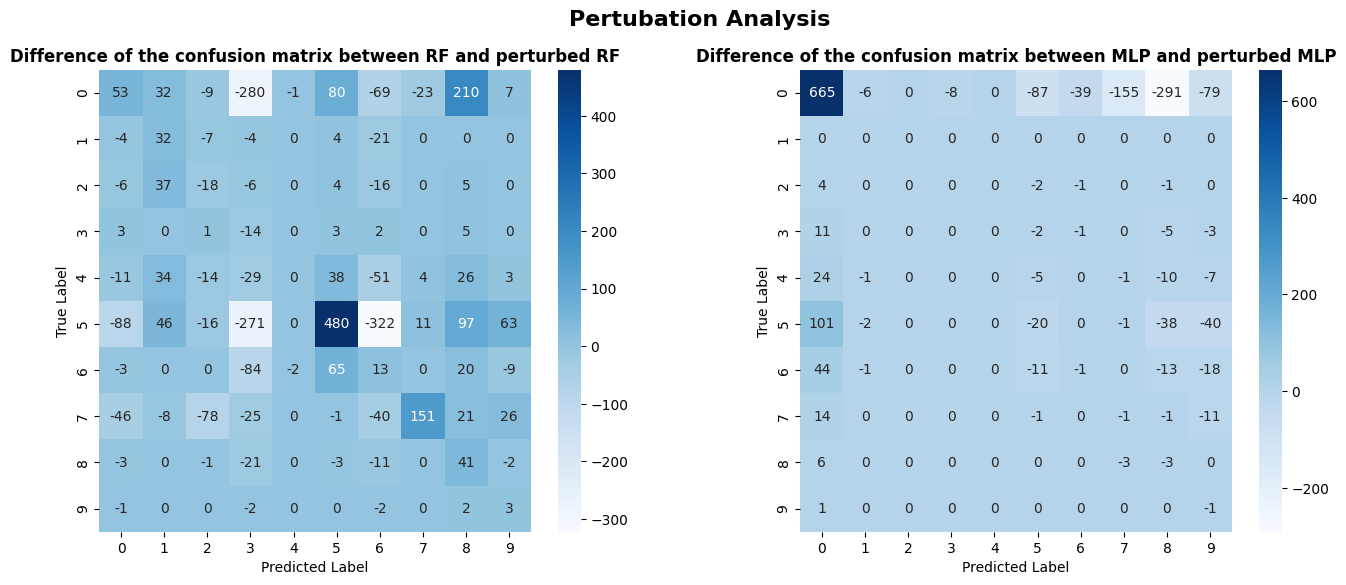

In [23]:
class_names = [str(i) for i in sorted(np.unique(y_train))]
import seaborn as sns
fig = plt.figure(figsize=(16, 6))
gs = fig.add_gridspec(1, 2, wspace=0.3)
        
# Plot confusion matrix (left)
ax_cm1 = fig.add_subplot(gs[0, 0])
sns.heatmap(comp_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=ax_cm1)
ax_cm1.set_title('Difference of the confusion matrix between RF and perturbed RF', fontsize=12, weight='bold')
ax_cm1.set_xlabel('Predicted Label')
ax_cm1.set_ylabel('True Label')
    
# Plot classification report table (right)
ax_cm2 = fig.add_subplot(gs[0, 1])
sns.heatmap(comp_mlp, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=ax_cm2)
ax_cm2.set_title('Difference of the confusion matrix between MLP and perturbed MLP', fontsize=12, weight='bold')
ax_cm2.set_xlabel('Predicted Label')
ax_cm2.set_ylabel('True Label')
    
fig.suptitle(f'Pertubation Analysis', fontsize=16, weight='bold')